In [1]:
# Cell 1: Imports and Setup
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import List, Tuple, Dict
import time
from collections import defaultdict

# OpenSpiel imports
import pyspiel
import open_spiel
from open_spiel.python import rl_environment
from open_spiel.python.algorithms import exploitability
from open_spiel.python.algorithms import nfsp
from open_spiel.python.algorithms.nfsp import MODE

# TensorFlow imports (OpenSpiel NFSP uses TensorFlow)
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

print("All imports successful!")

Instructions for updating:
non-resource variables are not supported in the long term
All imports successful!


In [2]:
# Cell 2: Initialize Game Environment
def setup_leduc_poker():
    """Setup Leduc Poker environment."""
    game_name = "leduc_poker"
    game = pyspiel.load_game(game_name)
    env = rl_environment.Environment(game)

    # Get game information
    info_state_size = game.information_state_tensor_shape()[0]
    num_actions = game.num_distinct_actions()
    num_players = 2

    print(f"Game: {game_name}")
    print(f"Number of players: {num_players}")
    print(f"Information state size: {info_state_size}")
    print(f"Number of actions: {num_actions}")

    return game, env, info_state_size, num_actions, num_players


game, env, info_state_size, num_actions, num_players = setup_leduc_poker()

Game: leduc_poker
Number of players: 2
Information state size: 30
Number of actions: 3


In [3]:
# Cell 3: NFSP Agent Configuration
def create_nfsp_agents(sess, info_state_size, num_actions, num_players):
    """Create NFSP agents with specified configuration."""

    # NFSP hyperparameters
    config = {
        "hidden_layers_sizes": [128],
        "replay_buffer_capacity": 200000,
        "reservoir_buffer_capacity": 2000000,
        "anticipatory_param": 0.1,
        "batch_size": 128,
        "rl_learning_rate": 0.1,
        "sl_learning_rate": 0.005,
        "min_buffer_size_to_learn": 1000,
        "learn_every": 64,
        "epsilon_start": 0.06,
        "epsilon_end": 0.001,
        "epsilon_decay_duration": int(1e6),
        "update_target_network_every": 300,
        "discount_factor": 0.99,
    }

    agents = []
    for player_id in range(num_players):
        agent = nfsp.NFSP(
            session=sess,
            player_id=player_id,
            state_representation_size=info_state_size,
            num_actions=num_actions,
            **config,
        )
        agents.append(agent)
        print(f"Created NFSP agent for player {player_id}")

    return agents, config


# Initialize TensorFlow session
sess = tf.Session()
agents, nfsp_config = create_nfsp_agents(
    sess, info_state_size, num_actions, num_players
)
sess.run(tf.global_variables_initializer())

print(f"Initialized {len(agents)} NFSP agents")

Created NFSP agent for player 0
Created NFSP agent for player 1
Initialized 2 NFSP agents


2025-08-22 14:26:09.120276: W tensorflow/c/c_api.cc:305] Operation '{name:'mlp_4/bias_1/Assign' id:540 op device:{requested: '', assigned: ''} def:{{{node mlp_4/bias_1/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@mlp_4/bias_1"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](mlp_4/bias_1, mlp_4/zeros_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
# Cell 4: Fixed Exploitability Computation


def compute_exploitability_approximate(game, agents, num_episodes=10000):
    """
    Approximate exploitability by measuring how much a best response can exploit the average policy.
    - Target player uses AVERAGE STRATEGY (is_evaluation=True)
    - Exploiting player uses BEST RESPONSE (RL policy with low epsilon)
    """
    total_exploitability = 0.0

    # for target_player in range(len(agents)):
    #     # Test how much the RL agent (best response) can exploit the target's average strategy
    #     test_env = rl_environment.Environment(game)
    #     exploiter_player = 1 - target_player  # The other player
    #     for agent in agents:
    #         agent._mode = MODE.best_response
    #     agents[target_player]._mode = MODE.average_policy
    #     rewards_vs_rl = []

    #     for episode in range(num_episodes):
    #         time_step = test_env.reset()
    #         episode_rewards = [0.0, 0.0]

    #         while not time_step.last():
    #             current_player = time_step.observations["current_player"]

    #             # TARGET PLAYER: Use AVERAGE STRATEGY (supervised learning policy)
    #             # This is the policy being evaluated for exploitability
    #             agent_output = agents[current_player].step(
    #                 time_step, is_evaluation=True
    #             )
    #             action = agent_output.action
    #             time_step = test_env.step([action])

    #             if time_step.rewards:
    #                 for i, reward in enumerate(time_step.rewards):
    #                     episode_rewards[i] += reward

    #         # How much did the RL agent (best response) gain against the average strategy?
    #         exploiter_reward = episode_rewards[exploiter_player]
    #         rewards_vs_rl.append(exploiter_reward)

    #     # Average exploitation value for this target player
    #     avg_exploitation = np.mean(rewards_vs_rl)
    #     total_exploitability += avg_exploitation
    #     print(f"Player {target_player} exploitability: {avg_exploitation:.6f}")

    # return total_exploitability / len(agents)


def compute_exploitability(game, agents):
    """
    Main exploitability function - measures how much best responses can exploit average strategies.
    """
    print("Computing exploitability using:")
    print("- Target players: Average strategy (evaluation mode)")
    print("- Exploiting players: Best response (RL policy with low epsilon)")
    return compute_exploitability_approximate(game, agents, num_episodes=50)


# Test the improved exploitability computation
print("Testing RL-based exploitability computation...")

initial_exploitability = compute_exploitability(game, agents)
print(f"Initial exploitability (RL vs Average): {initial_exploitability:.6f}")

Testing RL-based exploitability computation...
Computing exploitability using:
- Target players: Average strategy (evaluation mode)
- Exploiting players: Best response (RL policy with low epsilon)


AttributeError: 'NFSP' object has no attribute 'action_probabilities'

In [ ]:
# Cell 5: Training Episode Function
def train_episode(env, agents):
    """Train one episode and return episode statistics."""
    time_step = env.reset()
    episode_rewards = [0] * len(agents)
    steps = 0

    while not time_step.last():
        player_id = time_step.observations["current_player"]

        # Get action from NFSP agent
        agent_output = agents[player_id].step(time_step)
        action = agent_output.action

        # Execute action
        time_step = env.step([action])
        steps += 1

        # Accumulate rewards
        if time_step.rewards:
            for i, reward in enumerate(time_step.rewards):
                episode_rewards[i] += reward

    # Final step for agents
    for agent in agents:
        agent.step(time_step)

    return {
        "rewards": episode_rewards,
        "average_reward": np.mean(episode_rewards),
        "steps": steps,
    }


# Test one training episode
episode_stats = train_episode(env, agents)
print(f"Test episode completed: {episode_stats}")

Test episode completed: {'rewards': [-3.0, 3.0], 'average_reward': 0.0, 'steps': 4}


In [ ]:
# Cell 6: Main Training Loop with Periodic Evaluation
def train_nfsp_with_evaluation(game, env, agents, num_episodes=100000, eval_every=1000):
    """Main training loop with periodic exploitability evaluation."""

    # Training metrics
    training_metrics = {
        "episodes": [],
        "exploitability": [],
        "average_rewards": [],
        "training_time": [],
        "episode_lengths": [],
    }

    print(f"Starting NFSP training for {num_episodes} episodes...")
    print(f"Evaluating exploitability every {eval_every} episodes")

    start_time = time.time()

    for episode in range(num_episodes):
        # Train one episode
        episode_stats = train_episode(env, agents)

        # Periodic evaluation
        if (episode + 1) % eval_every == 0:
            print(f"\nEpisode {episode + 1}/{num_episodes}")

            # Compute exploitability
            current_exploitability = compute_exploitability(game, agents)

            # Record metrics
            training_metrics["episodes"].append(episode + 1)
            training_metrics["exploitability"].append(current_exploitability)
            training_metrics["average_rewards"].append(episode_stats["average_reward"])
            training_metrics["training_time"].append(time.time() - start_time)
            training_metrics["episode_lengths"].append(episode_stats["steps"])

            print(f"Exploitability: {current_exploitability:.6f}")
            print(f"Average episode reward: {episode_stats['average_reward']:.4f}")
            print(f"Average episode length: {episode_stats['steps']:.1f}")
            print(f"Time elapsed: {time.time() - start_time:.2f}s")

        # Progress indicator
        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}/{num_episodes} completed", end="\r")

    print(f"\nTraining completed in {time.time() - start_time:.2f}s")

    # Final evaluation
    final_exploitability = compute_exploitability(game, agents)
    print(f"Final exploitability: {final_exploitability:.6f}")

    return training_metrics


# # Run training - adjust num_episodes based on your computational resources
# training_metrics = train_nfsp_with_evaluation(
#     game,
#     env,
#     agents,
#     num_episodes=20000 * 64,  # Start with smaller number for testing
#     eval_every=128000 // 2,  # Evaluate more frequently for better tracking
# )

In [ ]:
# Cell 6: Main Training Loop with Periodic Evaluation
def train_nfsp_with_evaluation(game, env, agents, num_steps=20000, eval_every=1000):
    """Main training loop with periodic exploitability evaluation."""

    # Training metrics
    training_metrics = {
        "steps": [],
        "exploitability": [],
        "average_rewards": [],
        "training_time": [],
        "episode_lengths": [],
    }

    print(f"Starting NFSP training for {num_steps} steps...")
    print(f"Evaluating exploitability every {eval_every} steps")

    start_time = time.time()
    eval_points = []
    i = 0
    while i < num_steps:
        eval_points.append(i)
        i += eval_every
    print(eval_every)
    step = 0
    while step < num_steps:
        # Train one episode
        episode_stats = train_episode(env, agents)

        step += episode_stats["steps"]

        # Periodic evaluation

        if len(eval_points) > 0 and step > eval_points[0]:
            eval_points.pop(0)
            print(f"\nStep {step + 1}/{num_steps}")

            # Compute exploitability
            current_exploitability = compute_exploitability(game, agents)

            # Record metrics
            training_metrics["steps"].append(step + 1)
            training_metrics["exploitability"].append(current_exploitability)
            training_metrics["average_rewards"].append(episode_stats["average_reward"])
            training_metrics["training_time"].append(time.time() - start_time)
            training_metrics["episode_lengths"].append(episode_stats["steps"])

            print(f"Exploitability: {current_exploitability:.6f}")
            print(f"Average episode reward: {episode_stats['average_reward']:.4f}")
            print(f"Average episode length: {episode_stats['steps']:.1f}")
            print(f"Time elapsed: {time.time() - start_time:.2f}s")

        # Progress indicator
        if (step + 1) % 1000 == 0:
            print(f"Step {step + 1}/{num_steps} completed", end="\r")

    print(f"\nTraining completed in {time.time() - start_time:.2f}s")

    # Final evaluation
    final_exploitability = compute_exploitability(game, agents)
    print(f"Final exploitability: {final_exploitability:.6f}")

    return training_metrics


# Run training - adjust num_episodes based on your computational resources
training_metrics = train_nfsp_with_evaluation(
    game,
    env,
    agents,
    num_steps=20000 * 128,  # Start with smaller number for testing
    eval_every=1000 * 128,  # Evaluate more frequently for better tracking
)

Starting NFSP training for 2560000 steps...
Evaluating exploitability every 128000 steps
128000

Step 6/2560000
Computing exploitability using:
- Target players: Average strategy (evaluation mode)
- Exploiting players: Best response (RL policy with low epsilon)
Player 0 exploitability: -0.280000
Player 1 exploitability: 0.880000
Exploitability: 0.300000
Average episode reward: 0.0000
Average episode length: 5.0
Time elapsed: 0.04s
Step 126000/2560000 completed
Step 128003/2560000
Computing exploitability using:
- Target players: Average strategy (evaluation mode)
- Exploiting players: Best response (RL policy with low epsilon)
Player 0 exploitability: 0.800000
Player 1 exploitability: 2.840000
Exploitability: 1.820000
Average episode reward: 0.0000
Average episode length: 6.0
Time elapsed: 19.26s
Step 253000/2560000 completed
Step 256004/2560000
Computing exploitability using:
- Target players: Average strategy (evaluation mode)
- Exploiting players: Best response (RL policy with low e

KeyError: 'episodes'

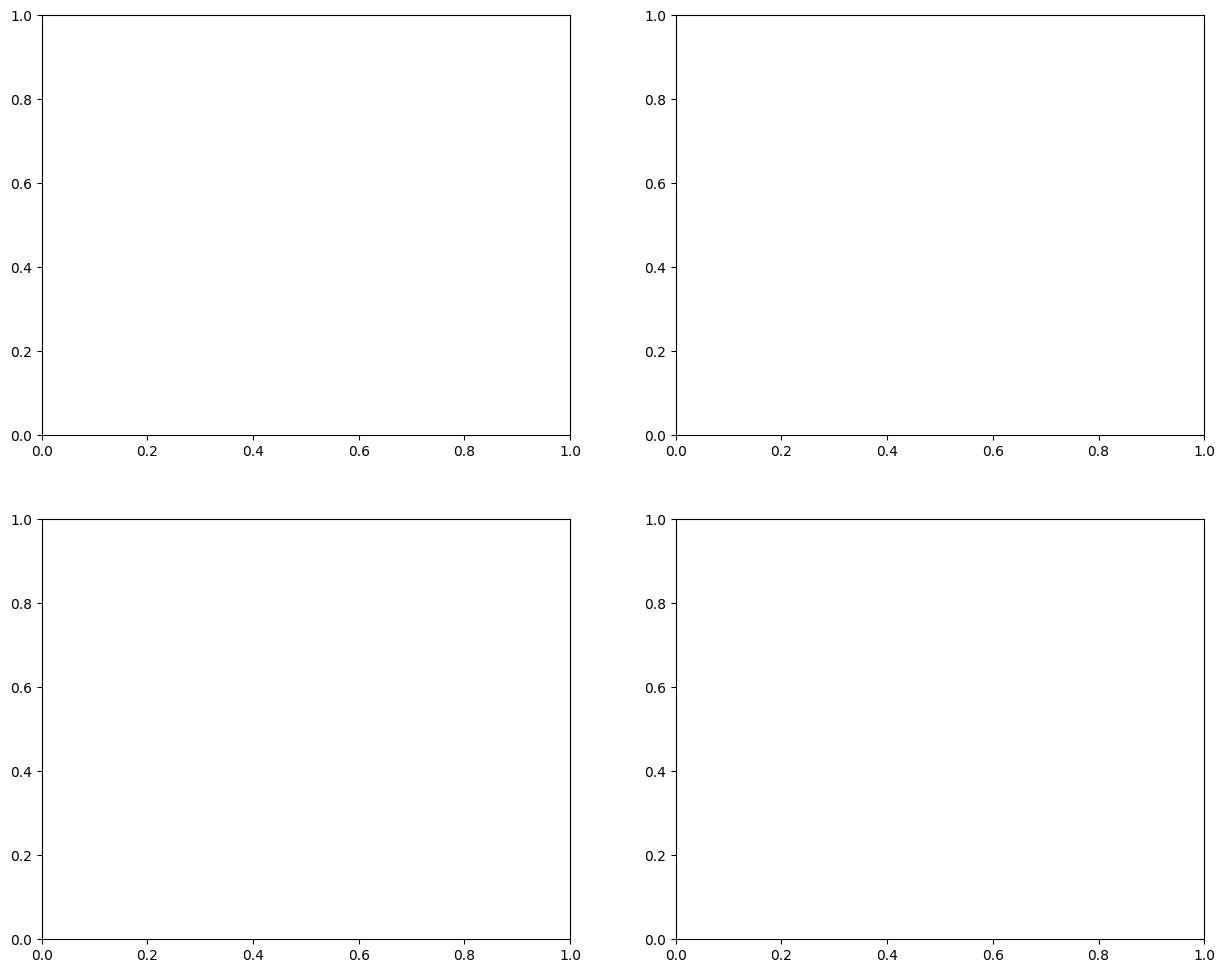

In [ ]:
# Cell 7: Visualize Training Progress
def plot_training_progress(training_metrics, save_path=None):
    """Plot training progress including exploitability and rewards."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    episodes = training_metrics["episodes"]
    exploitabilities = training_metrics["exploitability"]
    rewards = training_metrics["average_rewards"]
    times = training_metrics["training_time"]
    lengths = training_metrics["episode_lengths"]

    # Plot exploitability
    ax1.plot(episodes, exploitabilities, "b-", linewidth=2, label="Exploitability")
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Exploitability")
    ax1.set_title("NFSP Training Progress: Exploitability")
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_yscale("log")  # Log scale for better visualization

    # Plot average rewards
    ax2.plot(episodes, rewards, "r-", linewidth=2, label="Average Reward")
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Average Reward")
    ax2.set_title("NFSP Training Progress: Average Rewards")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Plot training time
    ax3.plot(
        episodes,
        np.array(times) / 60,
        "g-",
        linewidth=2,
        label="Training Time (minutes)",
    )
    ax3.set_xlabel("Episodes")
    ax3.set_ylabel("Training Time (minutes)")
    ax3.set_title("NFSP Training Progress: Time")
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Plot episode lengths
    ax4.plot(episodes, lengths, "m-", linewidth=2, label="Episode Length")
    ax4.set_xlabel("Episodes")
    ax4.set_ylabel("Steps per Episode")
    ax4.set_title("NFSP Training Progress: Episode Length")
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Training progress plot saved to {save_path}")

    plt.show()


# Plot training results
plot_training_progress(training_metrics, "nfsp_leduc_training_progress.png")

In [ ]:
# Cell 8: Detailed Exploitability Analysis
def analyze_exploitability_convergence(training_metrics):
    """Analyze exploitability convergence patterns."""
    episodes = np.array(training_metrics["episodes"])
    exploitabilities = np.array(training_metrics["exploitability"])

    print("=== Exploitability Analysis ===")
    print(f"Initial exploitability: {exploitabilities[0]:.6f}")
    print(f"Final exploitability: {exploitabilities[-1]:.6f}")
    print(f"Improvement factor: {exploitabilities[0] / exploitabilities[-1]:.2f}x")

    # Find episodes where exploitability dropped significantly
    for i in range(1, len(exploitabilities)):
        improvement = (
            exploitabilities[i - 1] - exploitabilities[i]
        ) / exploitabilities[i - 1]
        if improvement > 0.1:  # More than 10% improvement
            print(
                f"Significant improvement at episode {episodes[i]}: {improvement:.1%}"
            )

    # Convergence analysis
    final_quarter = exploitabilities[-len(exploitabilities) // 4 :]
    std_final = np.std(final_quarter)
    mean_final = np.mean(final_quarter)

    print(f"Final quarter mean exploitability: {mean_final:.6f}")
    print(f"Final quarter std deviation: {std_final:.6f}")
    print(f"Coefficient of variation: {std_final/mean_final:.2%}")

    if std_final / mean_final < 0.1:
        print("✓ Training appears to have converged (low variance in final quarter)")
    else:
        print("⚠ Training may need more episodes (high variance in final quarter)")


analyze_exploitability_convergence(training_metrics)

=== Exploitability Analysis ===
Initial exploitability: 2.050000
Final exploitability: 1.490000
Improvement factor: 1.38x
Significant improvement at episode 4000: 49.0%
Significant improvement at episode 5000: 15.2%
Significant improvement at episode 9000: 116.1%
Significant improvement at episode 10000: 380.6%
Significant improvement at episode 12000: 49.5%
Significant improvement at episode 13000: 10.6%
Significant improvement at episode 14000: 70.2%
Significant improvement at episode 16000: 91.4%
Significant improvement at episode 19000: 88.2%
Significant improvement at episode 24000: 27.2%
Significant improvement at episode 25000: 14.2%
Significant improvement at episode 27000: 14.4%
Significant improvement at episode 28000: 31.3%
Significant improvement at episode 32000: 34.0%
Significant improvement at episode 35000: 22.0%
Significant improvement at episode 36000: 52.5%
Significant improvement at episode 39000: 28.9%
Significant improvement at episode 41000: 38.2%
Significant imp

In [ ]:
# Cell 9: Test Trained Agents
def test_trained_agents(game, agents, num_test_games=1000):
    """Test the trained agents' performance."""
    print("=== Testing Trained Agents ===")

    # Test against random policy
    from open_spiel.python.algorithms import random_agent

    test_env = rl_environment.Environment(game)
    random_agents = [
        random_agent.RandomAgent(player_id=i, num_actions=num_actions)
        for i in range(num_players)
    ]

    nfsp_vs_random_rewards = []
    random_vs_nfsp_rewards = []

    # NFSP agents vs Random agents
    for _ in range(num_test_games // 2):
        time_step = test_env.reset()
        episode_rewards = [0, 0]

        while not time_step.last():
            player_id = time_step.observations["current_player"]

            if player_id == 0:  # NFSP agent
                # Use average policy for testing
                agent_output = agents[player_id].step(time_step, is_evaluation=True)
                action = agent_output.action
            else:  # Random agent
                action = random_agents[player_id].step(time_step).action

            time_step = test_env.step([action])

            if time_step.rewards:
                for i, reward in enumerate(time_step.rewards):
                    episode_rewards[i] += reward

        nfsp_vs_random_rewards.append(episode_rewards[0])

    # Random agents vs NFSP agents
    for _ in range(num_test_games // 2):
        time_step = test_env.reset()
        episode_rewards = [0, 0]

        while not time_step.last():
            player_id = time_step.observations["current_player"]

            if player_id == 0:  # Random agent
                action = random_agents[player_id].step(time_step).action
            else:  # NFSP agent
                agent_output = agents[player_id].step(time_step, is_evaluation=True)
                action = agent_output.action

            time_step = test_env.step([action])

            if time_step.rewards:
                for i, reward in enumerate(time_step.rewards):
                    episode_rewards[i] += reward

        random_vs_nfsp_rewards.append(episode_rewards[1])

    nfsp_avg_vs_random = np.mean(nfsp_vs_random_rewards)
    nfsp_avg_vs_random_std = np.std(nfsp_vs_random_rewards)
    random_avg_vs_nfsp = np.mean(random_vs_nfsp_rewards)

    print(
        f"NFSP agent vs Random: {nfsp_avg_vs_random:.4f} ± {nfsp_avg_vs_random_std:.4f}"
    )
    print(f"Random vs NFSP agent: {random_avg_vs_nfsp:.4f}")
    print(f"Combined NFSP performance: {(nfsp_avg_vs_random - random_avg_vs_nfsp):.4f}")

    return nfsp_vs_random_rewards, random_vs_nfsp_rewards


# Test the trained agents
nfsp_results, random_results = test_trained_agents(game, agents, num_test_games=1000)

=== Testing Trained Agents ===
NFSP agent vs Random: 1.2940 ± 4.4587
Random vs NFSP agent: 1.1580
Combined NFSP performance: 0.1360


In [ ]:
# Cell 10: Save Results and Models
def save_training_results(agents, training_metrics, save_dir="./nfsp_leduc_results"):
    """Save trained agents and training results."""
    os.makedirs(save_dir, exist_ok=True)

    # Save agents
    for i, agent in enumerate(agents):
        agent_path = os.path.join(save_dir, f"agent_{i}")
        agent.save(agent_path)
        print(f"Saved agent {i} to {agent_path}")

    # Save training metrics
    metrics_path = os.path.join(save_dir, "training_metrics.pkl")
    with open(metrics_path, "wb") as f:
        pickle.dump(training_metrics, f)
    print(f"Saved training metrics to {metrics_path}")

    # Save configuration
    config_path = os.path.join(save_dir, "config.pkl")
    with open(config_path, "wb") as f:
        pickle.dump(nfsp_config, f)
    print(f"Saved configuration to {config_path}")

    print(f"All results saved to {save_dir}")


# Save everything
save_training_results(agents, training_metrics)

Saved agent 0 to ./nfsp_leduc_results/agent_0
Saved agent 1 to ./nfsp_leduc_results/agent_1
Saved training metrics to ./nfsp_leduc_results/training_metrics.pkl
Saved configuration to ./nfsp_leduc_results/config.pkl
All results saved to ./nfsp_leduc_results


In [ ]:
# Cell 11: Cleanup
def cleanup_session(sess):
    """Close TensorFlow session."""
    sess.close()
    print("TensorFlow session closed")


# Uncomment the line below when you're done with training
# cleanup_session(sess)

print("NFSP training on Leduc Poker completed successfully!")
print(f"Final exploitability: {training_metrics['exploitability'][-1]:.6f}")

NFSP training on Leduc Poker completed successfully!
Final exploitability: 1.490000


In [ ]:
# Test both methods
print("Computing initial exploitability...")

try:
    initial_exploitability = compute_exploitability(game, agents)
    print(f"Initial exploitability: {initial_exploitability:.6f}")
except Exception as e:
    print(f"Exact exploitability failed: {e}")
    print("Using Nash convergence approximation instead...")
    initial_exploitability = compute_nash_conv_approximation(
        game, agents, num_samples=100
    )
    print(f"Initial Nash conv approximation: {initial_exploitability:.6f}")

Computing initial exploitability...
Computing exploitability using:
- Target players: Average strategy (evaluation mode)
- Exploiting players: Best response (RL policy with low epsilon)
Player 0 exploitability: 1.960000
Player 1 exploitability: 1.600000
Initial exploitability: 1.780000
